# EDA — Playing Card Detection

Load data.yaml, show class names, class distribution and display sample images with bounding boxes (YOLO format).

In [1]:
# Imports and locate data.yaml
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
import glob

# Path to data.yaml (relative to this notebook in scripts/)
yaml_path = Path('../PlayingCardDetection-1/data.yaml')
with open(yaml_path, 'r') as f:
    cfg = yaml.safe_load(f)
classes = cfg.get('names', [])
print(f"Found {len(classes)} classes")
print(classes)
train_dir = yaml_path.parent / 'train'
val_dir = yaml_path.parent / 'valid'
test_dir = yaml_path.parent / 'test'
print('\nPaths:')
print('train ->', train_dir)
print('val   ->', val_dir)
print('test  ->', test_dir)

Found 52 classes
['10C', '10D', '10H', '10S', '2C', '2D', '2H', '2S', '3C', '3D', '3H', '3S', '4C', '4D', '4H', '4S', '5C', '5D', '5H', '5S', '6C', '6D', '6H', '6S', '7C', '7D', '7H', '7S', '8C', '8D', '8H', '8S', '9C', '9D', '9H', '9S', 'AC', 'AD', 'AH', 'AS', 'JC', 'JD', 'JH', 'JS', 'KC', 'KD', 'KH', 'KS', 'QC', 'QD', 'QH', 'QS']

Paths:
train -> ..\PlayingCardDetection-1\train
val   -> ..\PlayingCardDetection-1\valid
test  -> ..\PlayingCardDetection-1\test


,class,count
0,4D,102
1,QD,101
2,8D,98
3,5C,93
4,3S,92
5,JS,90
6,7S,89
7,AS,89
8,4S,87
9,3H,86


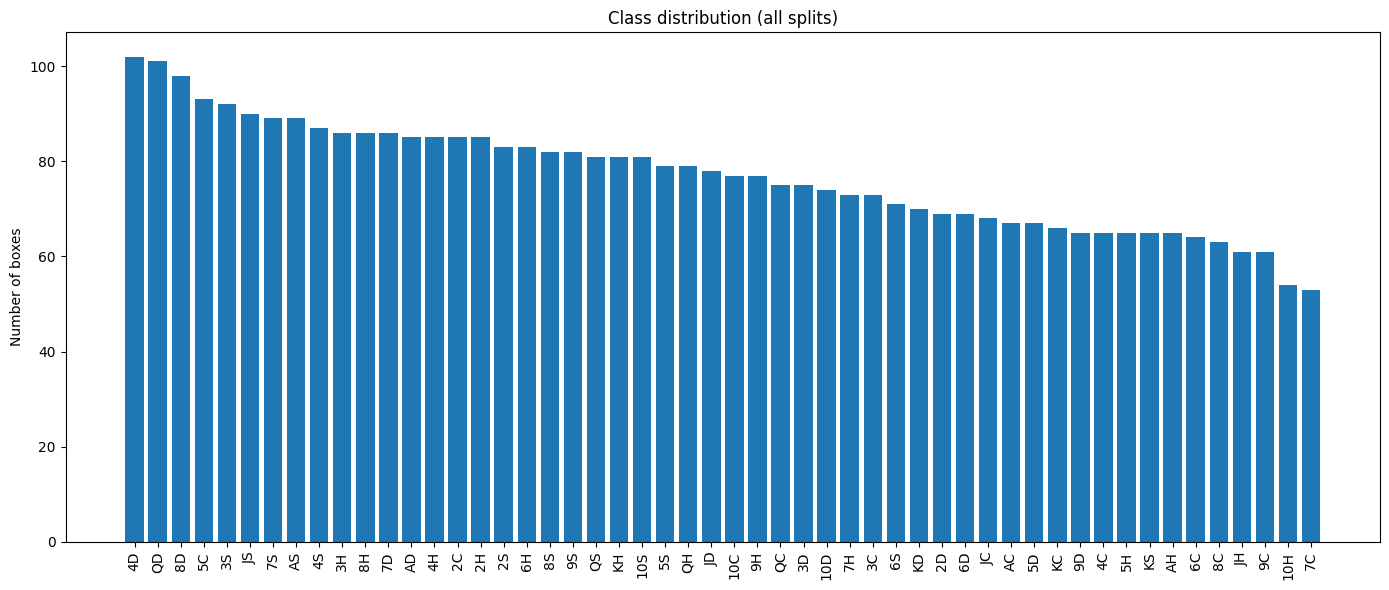

In [2]:
# Gather label files and compute class distribution
def gather_label_files(dirs):
    files = []
    for d in dirs:
        if d and Path(d).exists():
            for p in Path(d).rglob('*.txt'):
                files.append(p)
    return files

label_files = gather_label_files([train_dir, val_dir, test_dir])
counts = [0] * len(classes)
for lp in label_files:
    with open(lp, 'r') as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            cls = int(s.split()[0])
            counts[cls] += 1

df = pd.DataFrame({'class': classes, 'count': counts})
df_sorted = df.sort_values('count', ascending=False).reset_index(drop=True)
display(df_sorted)

plt.figure(figsize=(14,6))
plt.bar(df_sorted['class'], df_sorted['count'])
plt.xticks(rotation=90)
plt.title('Class distribution (all splits)')
plt.ylabel('Number of boxes')
plt.tight_layout()
plt.show()

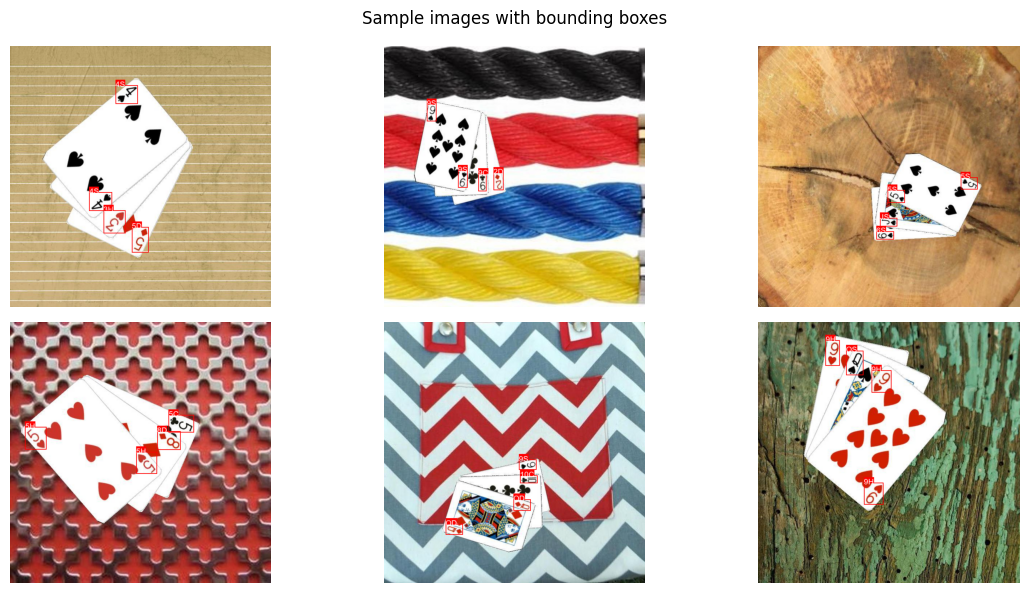

In [15]:
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path

def draw_boxes_on_image(img_path, label_path, class_names, font_scale=0.03):
    im = Image.open(img_path).convert('RGB')
    draw = ImageDraw.Draw(im)
    w, h = im.size

    # --- Bigger, scalable font ---
    font_size = int(min(w, h) * font_scale)   # scales with image size
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()  # fallback

    if label_path and Path(label_path).exists():
        with open(label_path, 'r') as f:
            for ln in f:
                parts = ln.strip().split()
                if not parts:
                    continue

                cls = int(parts[0])
                xc, yc, ww, hh = map(float, parts[1:5])

                x1 = (xc - ww/2) * w
                y1 = (yc - hh/2) * h
                x2 = (xc + ww/2) * w
                y2 = (yc + hh/2) * h

                draw.rectangle([x1, y1, x2, y2], outline='red', width=2)

                label_text = class_names[cls]

                # Text bounding box
                bbox = draw.textbbox((0, 0), label_text, font=font)
                text_w = bbox[2] - bbox[0]
                text_h = bbox[3] - bbox[1]

                # Background rectangle
                draw.rectangle([x1, y1 - text_h, x1 + text_w, y1],
                               fill="red")

                # Draw text
                draw.text((x1, y1 - text_h), label_text,
                          fill='white', font=font)

    return im



# Build label map from all splits (key = filename stem -> list of label paths)
label_files = gather_label_files([train_dir, val_dir, test_dir])
label_map = {}
for lf in label_files:
    label_map.setdefault(lf.stem, []).append(lf)

# collect image files from all splits (jpg/png/jpeg)
img_patterns = ['**/*.jpg', '**/*.jpeg', '**/*.png']
img_paths = []
for base in [train_dir, val_dir, test_dir]:
    if base and Path(base).exists():
        for pat in img_patterns:
            img_paths.extend(list(Path(base).rglob(pat)))
img_paths = [p for p in img_paths if p.exists()]
random.shuffle(img_paths)

def find_label_for_image(img_path, label_map):
    cands = label_map.get(img_path.stem, [])
    if not cands:
        return None
    # prefer a label in the same folder as the image
    for c in cands:
        if c.parent == img_path.parent:
            return c
    return cands[0]  # fallback to first match

n = min(6, len(img_paths))
if n == 0:
    print('No images found in dataset to display.')
else:
    sample = img_paths[:n]
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(4*cols, 3*rows))
    for i, p in enumerate(sample, 1):
        lp = find_label_for_image(p, label_map)
        im = draw_boxes_on_image(p, lp, classes)
        plt.subplot(rows, cols, i)
        plt.imshow(im)
        plt.axis('off')
    plt.suptitle('Sample images with bounding boxes')
    plt.tight_layout()
    plt.show()
# ...existing code...